In [1]:
#imports
import argparse
import json

import PIL
import nltk
import torch
import torch.nn as nn
import numpy as np
import os
import pickle
from torchtext.data.metrics import bleu_score
from PIL.Image import Image
from matplotlib import cm, image as mpimg

from FlickrDataLoder import get_loader
from FlickrJSON import FlickrJSON
from FlickrVocab import FlickrVocab
from model import EncoderCNN, DecoderRNN
import torch.nn.utils.rnn
from torchvision import transforms
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

C:\ProgramData\Anaconda3\envs\My_env\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\envs\My_Env\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Enable GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#Top-K Accuracy
def accuracy(scores, targets, k):
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [4]:
    parser = argparse.ArgumentParser()
    
    model_path = 'models/'
    crop_size = 224
    vocab_path = './Flickr8k_text/vocab.pkl'
    image_dir = './Flickr8k_Dataset/Flicker_Resized'
    caption_path = './Flickr8k_text/Flickr8k.token.txt'
    log_step = 10
    save_step = 1000

    # Model parameters
    embed_size=256
    hidden_size=512
    num_layers=1

    num_epochs=4
    batch_size=128
    num_workers=2
    learning_rate=0.001


    # Create model directory
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # Image preprocessing, normalization for the pretrained resnet
    transform = transforms.Compose([
        transforms.RandomCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    # print("Hello",vocab.idx2word[0])
    # Build data loader
    data_loader,Validationdata_loader,Testdata_loader = get_loader(image_dir,caption_path, vocab,
                             transform, batch_size,
                             shuffle=True, num_workers=num_workers)


    # Build the models
    encoder = EncoderCNN(embed_size).to(device)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    # Train the models
    total_step = len(data_loader)
    valtotal_step = len(Validationdata_loader)

train_loss_per_epoch=[]
train_accuracy_per_epoch=[]

test_loss_per_epoch=[]
test_accuracy_per_epoch=[]

    for epoch in range(num_epochs):
        train_loss = 0
        train_accuracy = 0

        test_loss = 0
        test_accuracy = 0

        epochtrainloss = []
        epochtestloss = []
        for i, (images, captions, lengths,file_name) in enumerate(data_loader):
#             print("Train Batch:", i)
            # Set mini-batch dataset
            images = images.to(device)
#             print("Images:", len(images), " captions:", len(captions))
            captions = captions.to(device)
            targets = torch.nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True)[0]
            # print(torch.nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True))
            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            # print(targets.shape)
            # print(outputs.shape)
            loss = criterion(outputs, targets)
            torch.set_printoptions(threshold=100000)
            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()
            epochtrainloss.append(loss.item())
            # print("outputs length:", len(outputs))
            # print("targets length: ", len(targets))
            # Print log info
            train_accuracy = accuracy(outputs, targets, 5)
            if i % log_step == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item())))
                print("Train Accuracy batch wise  Top-K:", train_accuracy)


            # Save the model checkpoints
            if (i + 1) % save_step == 0:
                torch.save(decoder.state_dict(), os.path.join(
                    model_path, 'decoder-{}-{}.ckpt'.format(epoch + 1, i + 1)))
                torch.save(encoder.state_dict(), os.path.join(
                    model_path, 'encoder-{}-{}.ckpt'.format(epoch + 1, i + 1)))
        train_loss_per_epoch.append(np.mean(epochtrainloss))
#         train_accuracy_per_epoch.append(train_accuracy)
            
        for j, (images, captions, lengths,file_name) in enumerate(Validationdata_loader):
#             print("Validation Batch:", j)
            # Set mini-batch dataset
            images = images.to(device)
#             print("Images:", len(images), " captions:", len(captions))
            captions = captions.to(device)
            targets = torch.nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True)[0]
            # print(torch.nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True))
            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            valloss = criterion(outputs, targets)
            torch.set_printoptions(threshold=100000)
            epochtestloss.append(valloss.item())
            # print("outputs length:", len(outputs))
            # print("targets length: ", len(targets))
            # Print log info
            if j % 5 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Validation Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, num_epochs, j, valtotal_step, valloss.item(), np.exp(valloss.item())))
            top5 = accuracy(outputs, targets, 5)
            print("Validation Accuracy batch wise  Top-K:", top5)

        test_loss_per_epoch.append(np.mean(epochtestloss))
#         test_accuracy = test_accuracy/Test_Length
#         test_accuracy_per_epoch.append(test_accuracy)

Epoch [0/4], Step [0/253], Loss: 8.1439, Perplexity: 3442.3920
Train Accuracy batch wise  Top-K: 0.16806722689075632
Epoch [0/4], Step [10/253], Loss: 5.3792, Perplexity: 216.8397
Train Accuracy batch wise  Top-K: 37.478897017445135
Epoch [0/4], Step [20/253], Loss: 4.9266, Perplexity: 137.9161
Train Accuracy batch wise  Top-K: 41.84476940382452
Epoch [0/4], Step [30/253], Loss: 4.4595, Perplexity: 86.4455
Train Accuracy batch wise  Top-K: 45.83333333333333
Epoch [0/4], Step [40/253], Loss: 4.1337, Perplexity: 62.4054
Train Accuracy batch wise  Top-K: 50.878220140515225
Epoch [0/4], Step [50/253], Loss: 3.8819, Perplexity: 48.5182
Train Accuracy batch wise  Top-K: 52.56983240223463
Epoch [0/4], Step [60/253], Loss: 3.8168, Perplexity: 45.4583
Train Accuracy batch wise  Top-K: 53.28983143012507
Epoch [0/4], Step [70/253], Loss: 3.6412, Perplexity: 38.1369
Train Accuracy batch wise  Top-K: 56.01589103291714
Epoch [0/4], Step [80/253], Loss: 3.5814, Perplexity: 35.9241
Train Accuracy batc

Images: 128  captions: 128


C:\ProgramData\Anaconda3\envs\My_env\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\ProgramData\Anaconda3\envs\My_env\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\ProgramData\Anaconda3\envs\My_env\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

image: 0    862156271_3eacea90a8.jpg
Predicted: <start> a woman in a white shirt and a woman in a blue shirt and a woman in a <unk>
Groundtruth: girls with orange hair standing on the street with some kind of bottle in their hand .
BLEU SCORE: 0
Groundtruth: two girls walking in the street
BLEU SCORE: 0
Groundtruth: two girls walking next to each other and talking .
BLEU SCORE: 0
Groundtruth: two teenage girls dressed like hippies walk and talk .
BLEU SCORE: 0
Groundtruth: two women , one with a head bandanna , are standing next to each other while one holds a bottle .
BLEU SCORE: 8.510469113101058e-232
image: 1    1388346434_524d0b6dfa.jpg
Predicted: <start> a man in a blue shirt is sitting on a bench and a woman in a black shirt .
Groundtruth: a man , leaning against a concrete wall with his arms resting on top , looks over a balcony .
BLEU SCORE: 1.0244914152188952e-231
Groundtruth: a man with a white mustache stands on a balcony looking at the road below .
BLEU SCORE: 1.08326778209

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image: 8    289860281_94d699f36d.jpg
Predicted: <start> a woman in a blue shirt is holding a baby in a pool . <end> . <end> . <end>
Groundtruth: a girl in a bikini , glasses and black hat laying on a white towel on the beach .
BLEU SCORE: 1.0377133938315695e-231
Groundtruth: a girl in a black hat wears a bikini at the beach .
BLEU SCORE: 1.1409851298103347e-231
Groundtruth: a woman in a black cap is laying on the beach in a pink bikini .
BLEU SCORE: 1.0832677820940877e-231
Groundtruth: girl with black hat and sunglasses lying on towel at beach
BLEU SCORE: 0
Groundtruth: young lady in bikini lying on the beach
BLEU SCORE: 0
image: 9    3276475986_66cd9cc7e4.jpg
Predicted: <start> a woman in a red shirt is holding a cup . <end> . <end> <end> . <end> . <end>
Groundtruth: asian women standing near a pole .
BLEU SCORE: 1.331960397810445e-231
Groundtruth: several asian women are standing on the street .
BLEU SCORE: 1.0518351895246305e-231
Groundtruth: the four asian girls are standing on a s

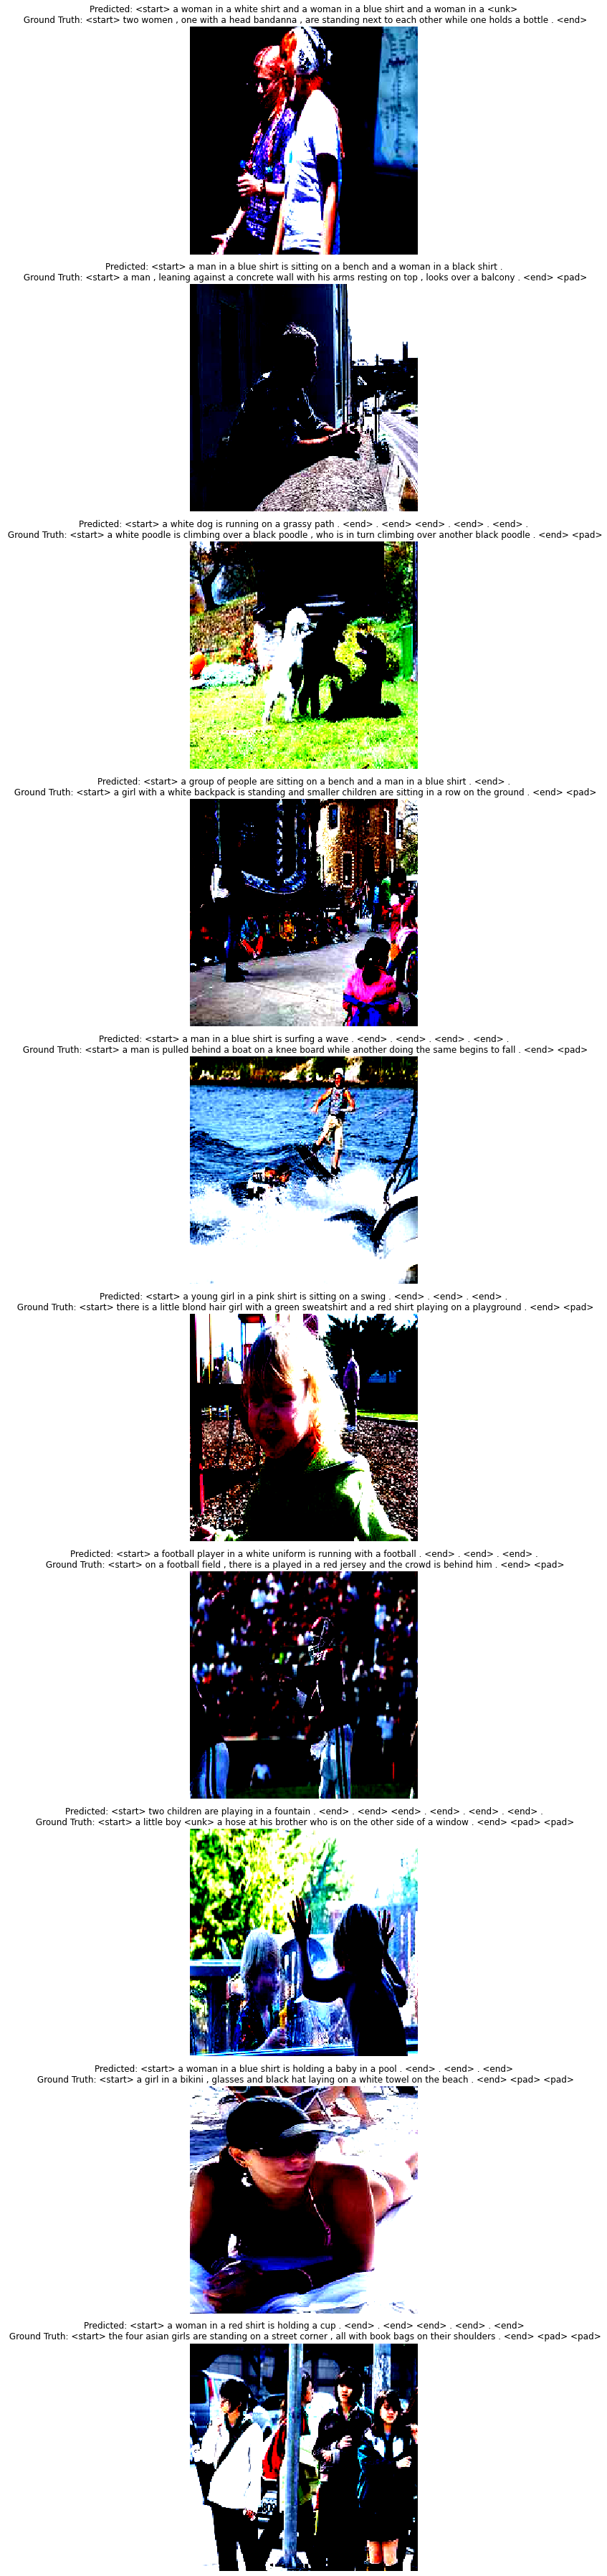

In [5]:
flickj = FlickrJSON()
JSON_data = flickj.BuildJson(caption_path)
pythonObj = json.loads(JSON_data)
    
data = next(iter(Testdata_loader))
(images, captions, lengths,file_name) = data[0:10]
# Set mini-batch dataset
cpuimages = images
images = images.to(device)
print("Images:", len(images), " captions:", len(captions))
cpucaptions = captions.numpy()
captions = captions.to(device)
targets = torch.nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True)[0]
# print(torch.nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True))
# Forward, backward and optimize
features = encoder(images)
outputs = decoder.sample(features)
cpuoutputs = outputs.cpu().detach().numpy()

fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(50,50))

u = 0
for ax in axs.reshape(-1):
    f = u
    print("image:", f,"  ",file_name[f])
    predictedcaption = []
    groundcaption = []
    lists = []
    for i in range(len(pythonObj['annotations'])):
        if(pythonObj['annotations'][i]['file_name']  == file_name[f]):
                caption = str(pythonObj['annotations'][i]['caption'])
                tokens = nltk.tokenize.word_tokenize(caption.lower())
                lists.append(tokens)

    for k1 in range(len(cpuoutputs[f])):
        predictedcaption.append(vocab.idx2word[cpuoutputs[f][k1]])
    for k1 in range(len(cpucaptions[f])):
        groundcaption.append(vocab.idx2word[cpucaptions[f][k1]])
    print("Predicted:",' '.join(predictedcaption))
#             print("All captions:",lists)

    for candidate in lists:
        print("Groundtruth:", ' '.join(candidate))
        score = sentence_bleu(predictedcaption, candidate)
        print("BLEU SCORE:",score)

    ax.set_title("Predicted: "+' '.join(predictedcaption)+ "\n Ground Truth: " +' '.join(groundcaption))
    ax.imshow((cpuimages.cpu().numpy())[u].transpose(1,2,0), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    ax.axis('off')
    u += 1
plt.tight_layout()   
plt.show()


In [6]:
# print("Final Train Accuracy: ", train_accuracy_per_epoch[-1])
print("Final Train Loss: ", train_loss_per_epoch[-1])

# print("Final Test Accuracy: ", test_accuracy_per_epoch[-1])
print("Final Test Loss: ", test_loss_per_epoch[-1])

Final Train Loss:  2.3553513566495874
Final Test Loss:  2.4526837840676308


(array([2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

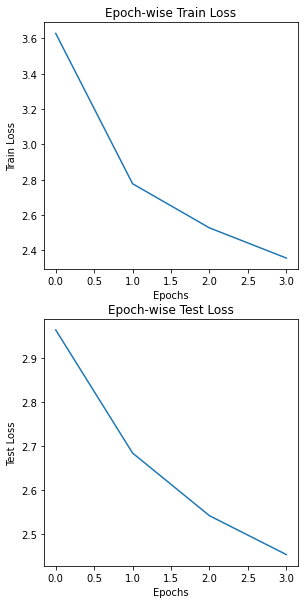

In [7]:
import matplotlib.pyplot as plt

fig1 = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title("Epoch-wise Train Loss")
plt.plot(train_loss_per_epoch)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Train Loss', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# plt.subplot(2,2,2)
# plt.title("Epoch-wise Train Accuracy")
# plt.plot(train_accuracy_per_epoch)
# print("Train Accuracy:",(train_accuracy_per_epoch[-1]) )
# plt.xlabel('Epochs', fontsize=10)
# plt.ylabel('Train Accuracy', fontsize=10)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)

plt.subplot(2,2,3)
plt.title("Epoch-wise Test Loss")
plt.plot(test_loss_per_epoch)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Test Loss', fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# plt.subplot(2,2,4)
# plt.title("Epoch-wise Test Accuracy")
# plt.plot(test_accuracy_per_epoch)
# plt.xlabel('Epochs', fontsize=10)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.ylabel('Test Accuracy', fontsize=10)
# print("Test Accuracy:",(test_accuracy_per_epoch[-1]) )

(array([2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

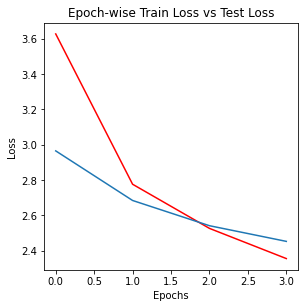

In [8]:
fig1 = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title("Epoch-wise Train Loss vs Test Loss")
plt.plot(train_loss_per_epoch, color ='red')
plt.plot(test_loss_per_epoch)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# plt.subplot(2,2,2)
# plt.title("Epoch-wise Train Accuracy vs Test Accuracy")
# plt.plot(train_accuracy_per_epoch, color ='red')
# plt.plot(test_accuracy_per_epoch)
# print("Train Accuracy:",(train_accuracy_per_epoch[-1]) )
# plt.xlabel('Epochs', fontsize=10)
# plt.ylabel('Accuracy', fontsize=10)
# # plt.xticks(fontsize=10)
# # plt.yticks(fontsize=10)